In [45]:
#!pip install --upgrade scikit-learn
#!pip install xgboost

In [46]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e14/sample_submission.csv
/kaggle/input/playground-series-s3e14/train.csv
/kaggle/input/playground-series-s3e14/test.csv


In [48]:
df = pd.read_csv("/kaggle/input/playground-series-s3e14/train.csv", index_col=0)

In [49]:
df.head()

clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
id                                                                   
0       25.00      0.50     0.25     0.75   0.50             69.70   
1       25.00      0.50     0.25     0.50   0.50             69.70   
2       12.50      0.25     0.25     0.63   0.63             86.00   
3       12.50      0.25     0.25     0.63   0.50             77.40   
4       25.00      0.50     0.25     0.63   0.63             77.40   

    MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
id                                                             
0              42.10                 58.20             50.20   
1              42.10                 58.20             50.20   
2              52.00                 71.90             62.00   
3              46.80                 64.70             55.80   
4              46.80                 64.70             55.80   

    MinOfLowerTRange  AverageOfLowerTRange  RainingDays  AverageRainingDays  \
id                                                                            
0              24.30                 41.20        24.00                0.39   
1              24.30                 41.20        24.00                0.39   
2              30.00                 50.80        24.00                0.39   
3              27.00                 45.80        24.00                0.39   
4              27.00                 45.80        24.00                0.39   

    fruitset  fruitmass  seeds   yield  
id                                      
0       0.43       0.42  32.46 4476.81  
1       0.44       0.42  33.86 5548.12  
2       0.55       0.47  38.34 6869.78  
3       0.57       0.48  39.47 6880.78  
4       0.58       0.49  40.48 7479.93

In [50]:
df.describe()

clonesize  honeybee  bumbles  andrena    osmia  MaxOfUpperTRange  \
count   15289.00  15289.00 15289.00 15289.00 15289.00          15289.00   
mean       19.70      0.39     0.29     0.49     0.59             82.17   
std         6.60      0.36     0.06     0.15     0.14              9.15   
min        10.00      0.00     0.00     0.00     0.00             69.70   
25%        12.50      0.25     0.25     0.38     0.50             77.40   
50%        25.00      0.50     0.25     0.50     0.63             86.00   
75%        25.00      0.50     0.38     0.63     0.75             86.00   
max        40.00     18.43     0.58     0.75     0.75             94.60   

       MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
count          15289.00              15289.00          15289.00   
mean              49.67                 68.66             59.23   
std                5.55                  7.64              6.61   
min               39.00                 58.20             50.20   
25%               46.80                 64.70             55.80   
50%               52.00                 71.90             62.00   
75%               52.00                 71.90             62.00   
max               57.20                 79.00             68.20   

       MinOfLowerTRange  AverageOfLowerTRange  RainingDays  \
count          15289.00              15289.00     15289.00   
mean              28.66                 48.57        18.66   
std                3.20                  5.39        11.66   
min               24.30                 41.20         1.00   
25%               27.00                 45.80        16.00   
50%               30.00                 50.80        16.00   
75%               30.00                 50.80        24.00   
max               33.00                 55.90        34.00   

       AverageRainingDays  fruitset  fruitmass    seeds    yield  
count            15289.00  15289.00   15289.00 15289.00 15289.00  
mean                 0.32      0.50       0.45    36.16  6025.19  
std                  0.16      0.07       0.04     4.03  1337.06  
min                  0.06      0.19       0.31    22.08  1945.53  
25%                  0.26      0.46       0.42    33.23  5128.16  
50%                  0.26      0.51       0.45    36.04  6117.48  
75%                  0.39      0.56       0.47    39.16  7019.69  
max                  0.56      0.65       0.54    46.59  8969.40

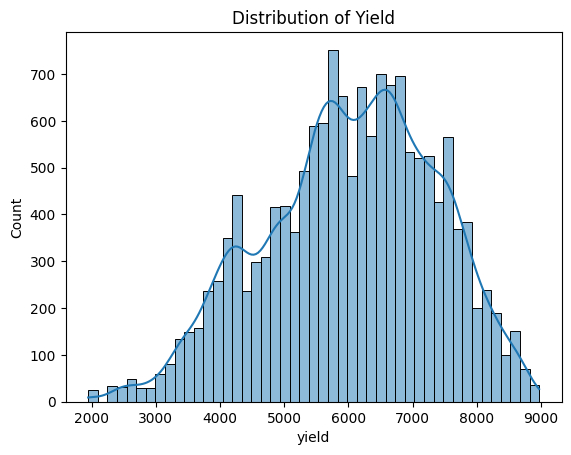

In [51]:
sns.histplot(df['yield'], kde=True)
plt.title("Distribution of Yield")
plt.show()

In [52]:
X = df.drop(columns=['yield'])
y = df['yield']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [53]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12231, 16)
X_test shape: (3058, 16)
y_train shape: (12231,)
y_test shape: (3058,)


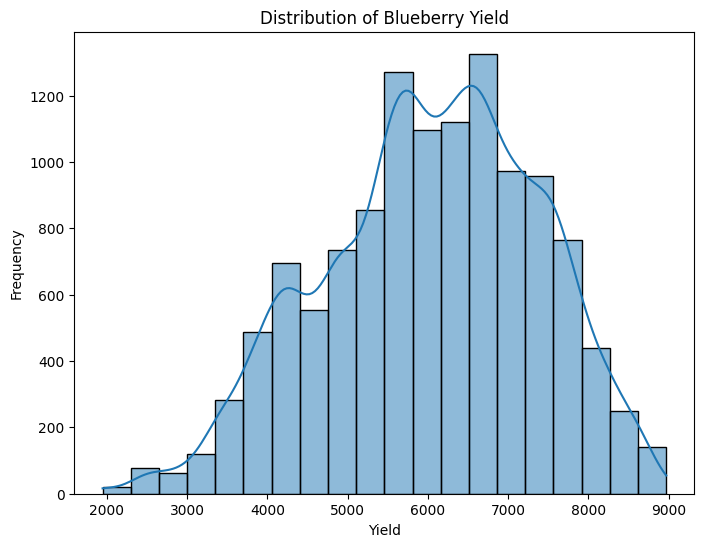

In [54]:
plt.figure(figsize=(8, 6))
sns.histplot(y_train, bins=20, kde=True)
plt.title('Distribution of Blueberry Yield')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.show()

In [55]:
train = X_train.copy()
train['yield'] = y_train

# Histograms

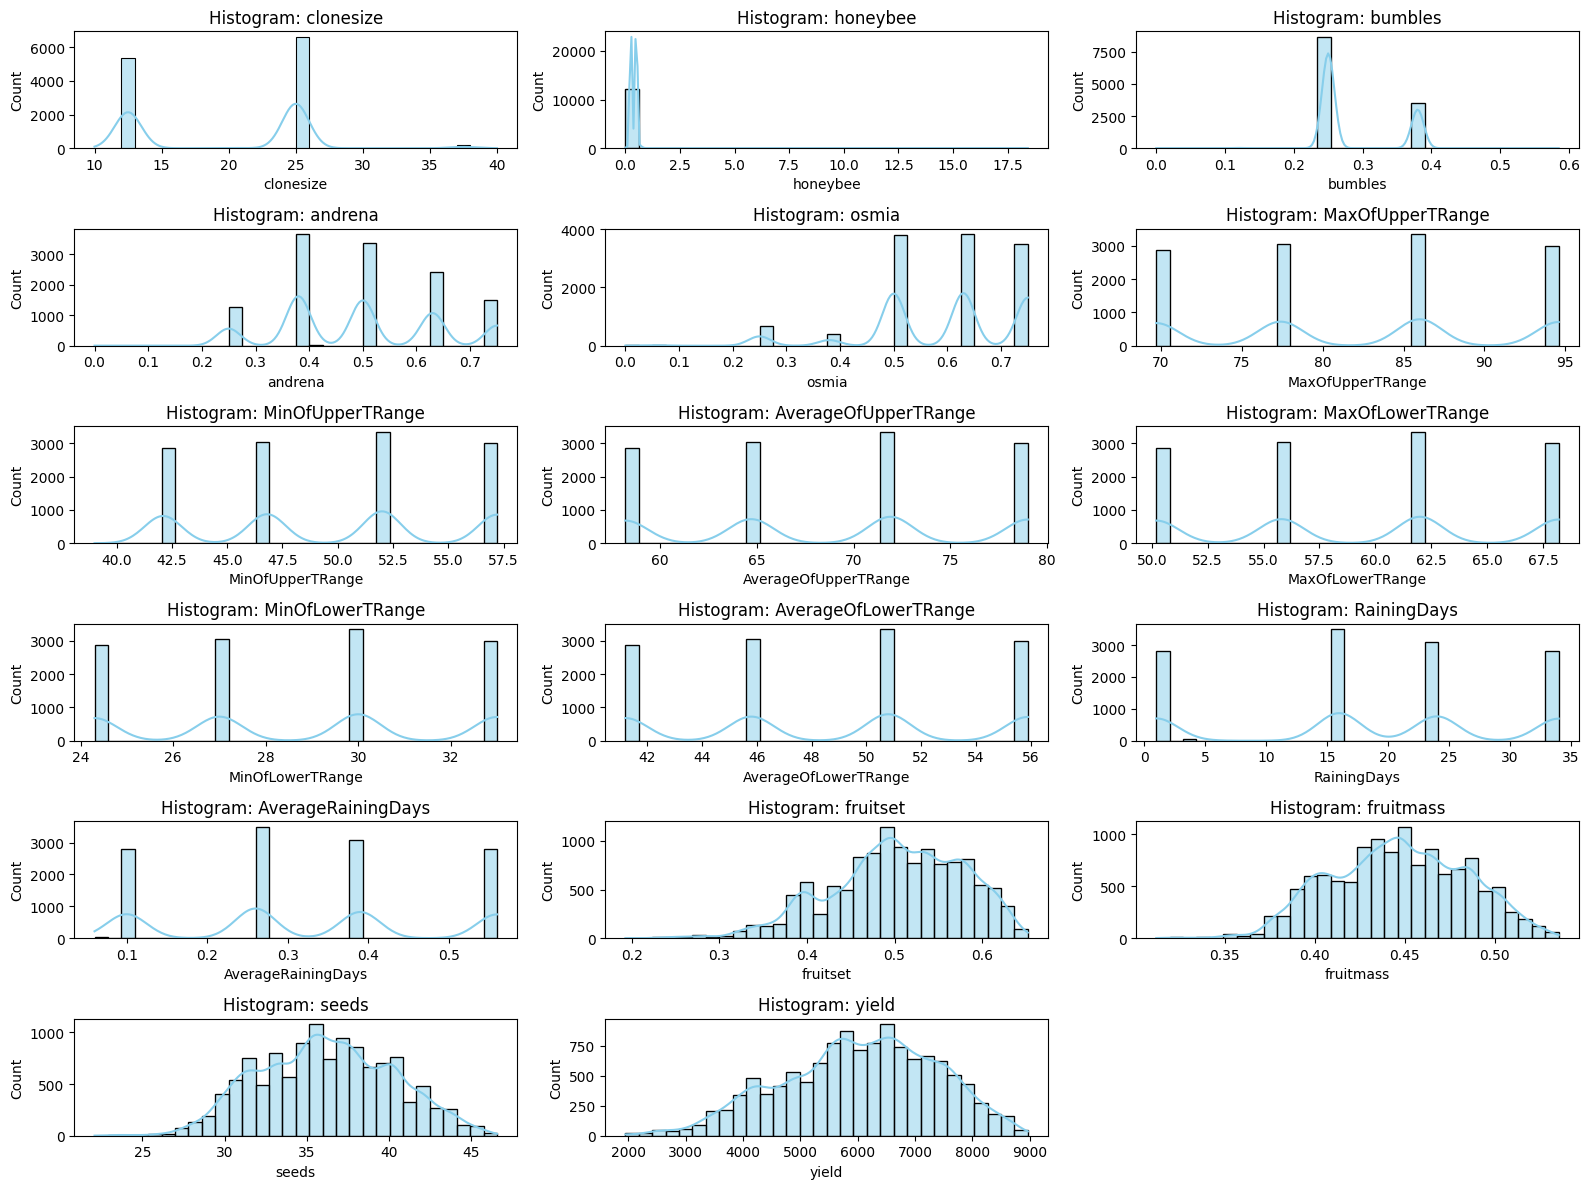

In [56]:
numeric_cols = train.select_dtypes(include='number').columns

plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) - 1) // 3 + 1, 3, i + 1)
    sns.histplot(train[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Histogram: {col}")
    plt.tight_layout()
plt.show()

# Boxplots

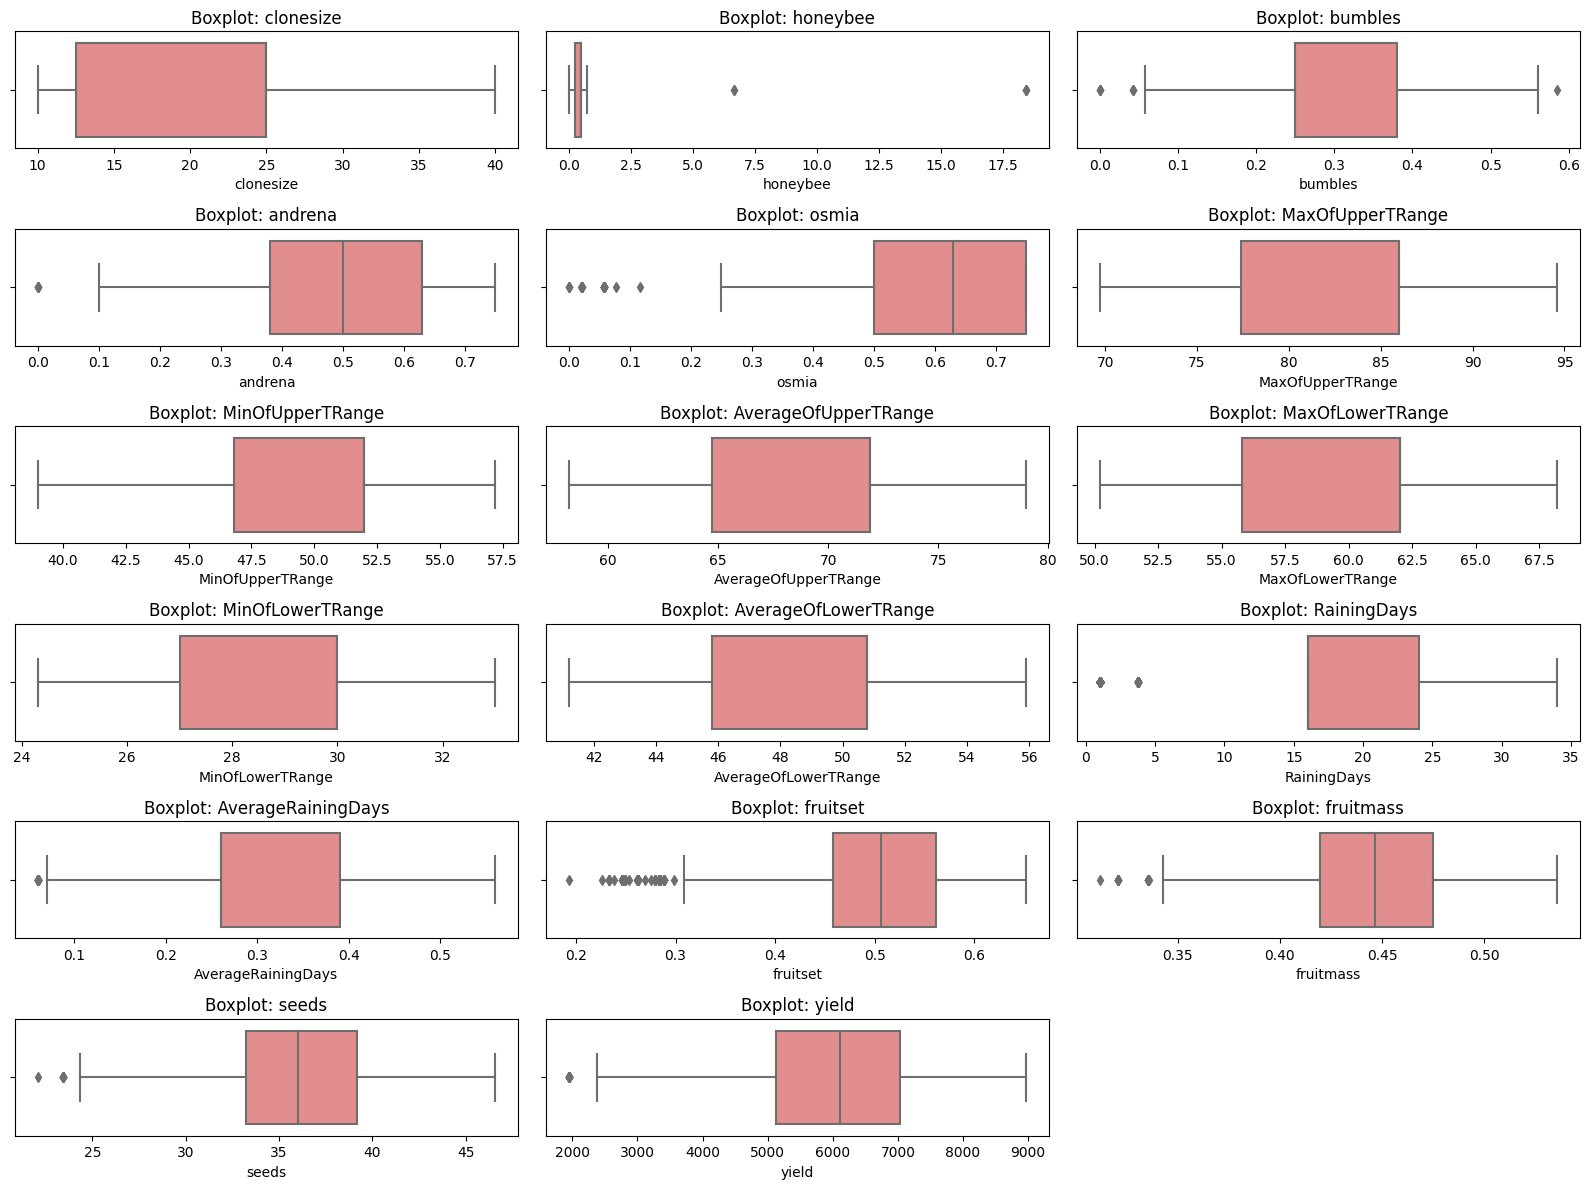

In [57]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) - 1) // 3 + 1, 3, i + 1)
    sns.boxplot(x=train[col], color='lightcoral')
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
plt.show()

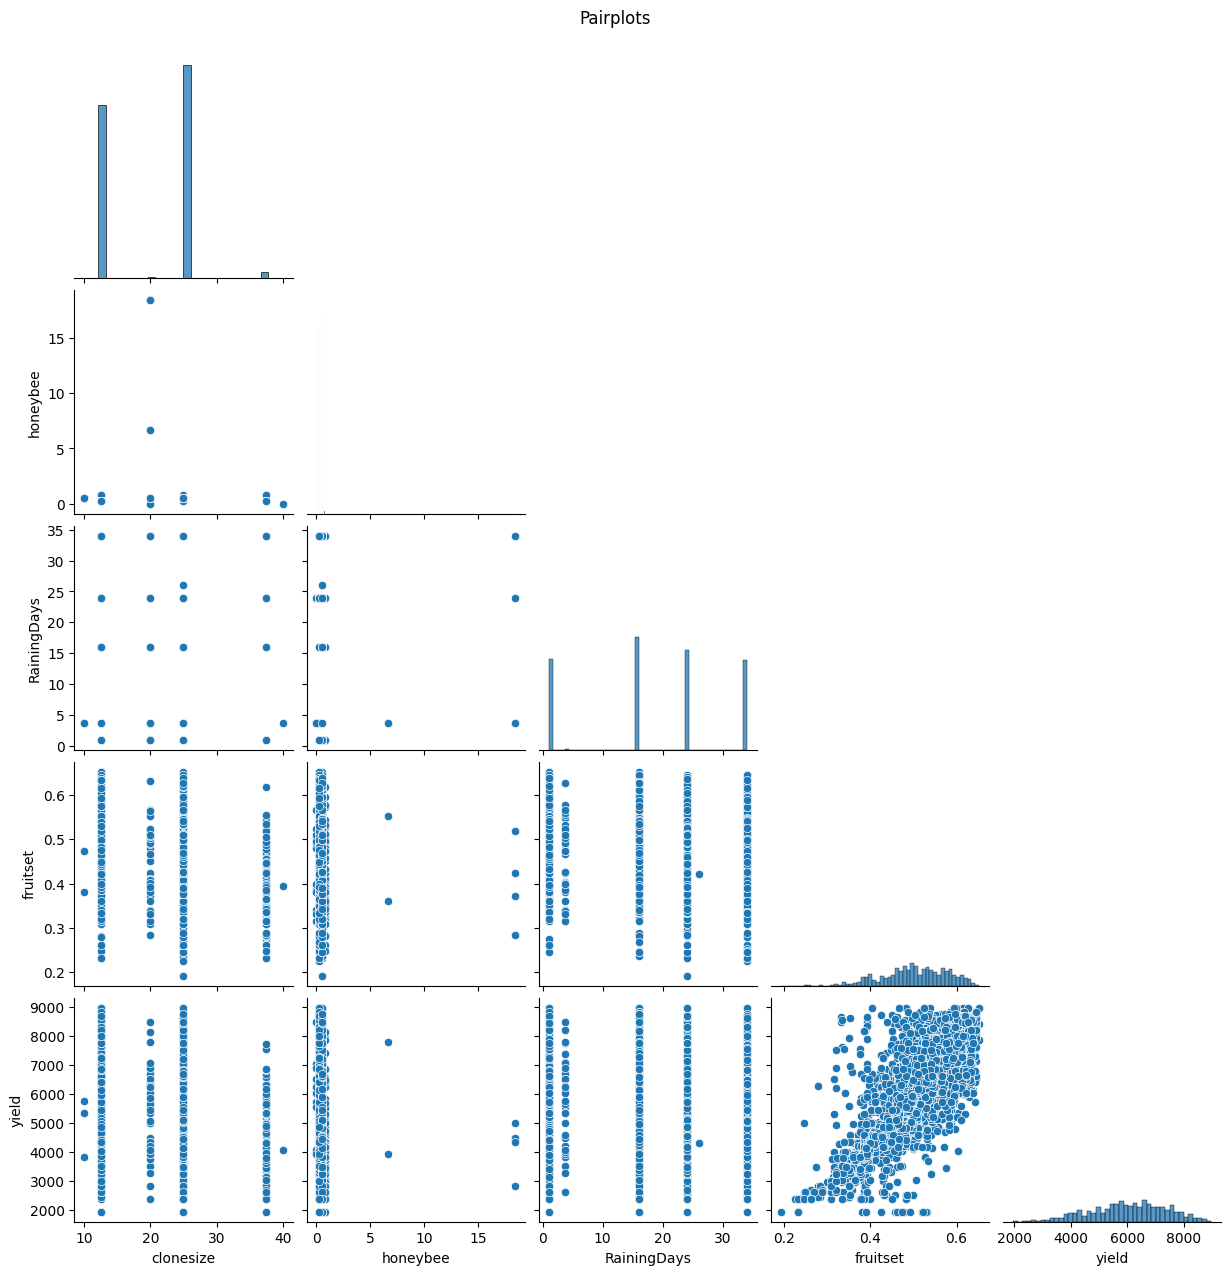

In [58]:
selected = ['clonesize', 'honeybee', 'RainingDays', 'fruitset', 'yield']
sns.pairplot(train[selected], corner=True)
plt.suptitle("Pairplots", y=1.02)
plt.show()

# IQR

In [59]:
numeric_cols = train.select_dtypes(include='number').columns

outlier_counts = pd.Series(dtype=int)

for col in numeric_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train[(train[col] < lower_bound) | (train[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]

outlier_counts = outlier_counts.sort_values(ascending=False)
print(outlier_counts)

RainingDays             2853
fruitset                  76
osmia                     42
AverageRainingDays        40
yield                     20
fruitmass                 17
seeds                     11
bumbles                    8
andrena                    6
honeybee                   6
clonesize                  0
AverageOfLowerTRange       0
MinOfLowerTRange           0
AverageOfUpperTRange       0
MinOfUpperTRange           0
MaxOfUpperTRange           0
MaxOfLowerTRange           0
dtype: int64


In [60]:
def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

# Correlation

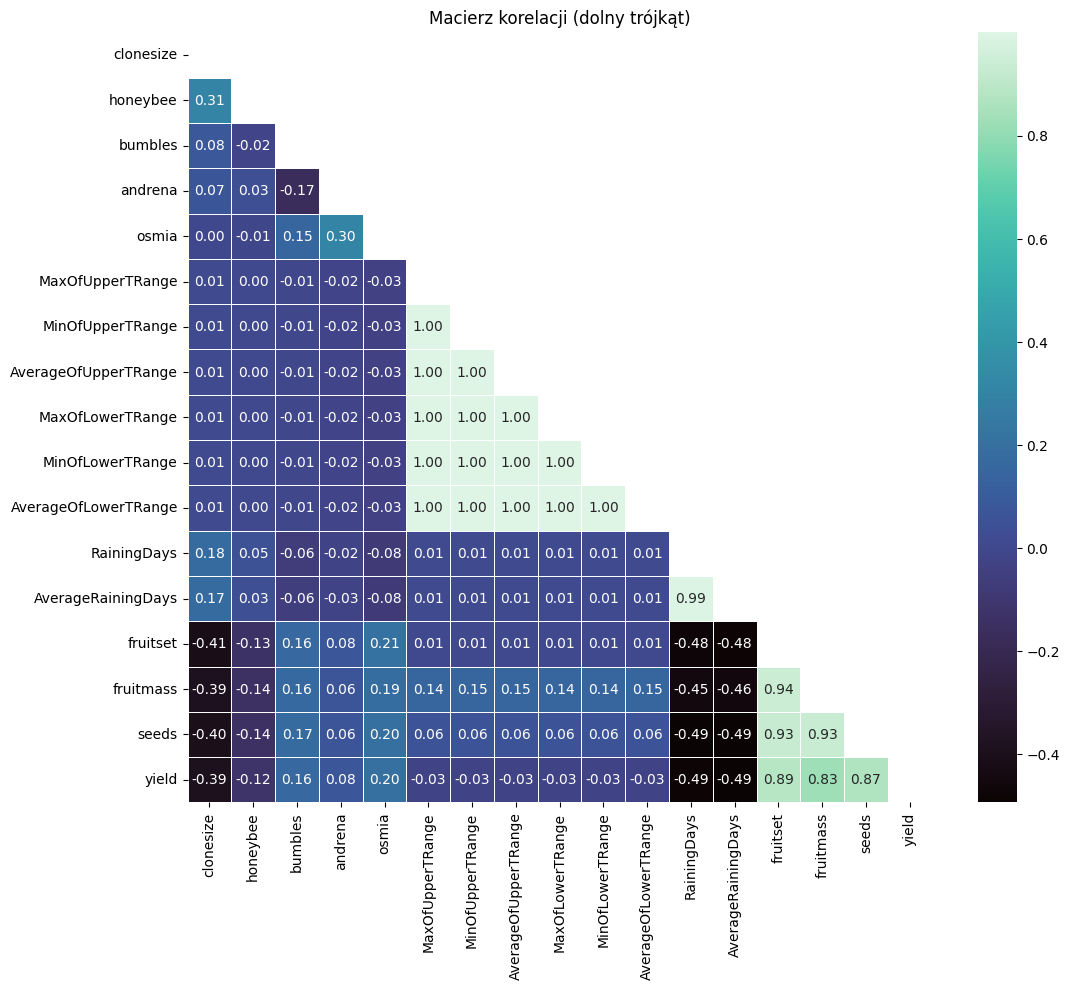

In [61]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako', fmt=".2f", linewidths=0.5)
plt.title('Macierz korelacji (dolny trójkąt)')
plt.show()

# Linear Regression

## Collinearity

In [62]:
pd.options.display.float_format = '{:.2f}'.format

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data)

                 feature        VIF
0              clonesize      13.15
1               honeybee       2.42
2                bumbles      27.23
3                andrena      14.24
4                  osmia      22.91
5       MaxOfUpperTRange  251721.89
6       MinOfUpperTRange   37042.52
7   AverageOfUpperTRange 2287167.75
8       MaxOfLowerTRange   90801.94
9       MinOfLowerTRange 1691337.88
10  AverageOfLowerTRange 1807104.65
11           RainingDays     203.03
12    AverageRainingDays     279.28
13              fruitset     455.61
14             fruitmass    1242.90
15                 seeds     789.65


In [63]:
regr_X_train = X_train.drop(columns=['MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'AverageOfUpperTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'AverageRainingDays', 'andrena', 'osmia', 'bumbles', 'fruitmass', 'seeds'])
regr_X_test = X_test.drop(columns=['MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'AverageOfUpperTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'AverageRainingDays', 'andrena', 'osmia', 'bumbles', 'fruitmass', 'seeds'])

In [64]:
pd.options.display.float_format = '{:.2f}'.format

vif_data = pd.DataFrame()
vif_data["feature"] = regr_X_train.columns
vif_data["VIF"] = [variance_inflation_factor(regr_X_train.values, i) for i in range(regr_X_train.shape[1])]

print(vif_data)

       feature  VIF
0    clonesize 8.91
1     honeybee 2.39
2  RainingDays 3.38
3     fruitset 6.65


In [65]:
columns_to_clean = ['fruitmass', 'seeds', 'honeybee']
train_cleaned = remove_outliers_iqr(train, columns_to_clean)
print(train_cleaned.shape)

regr_X_train = train_cleaned.drop(columns=['yield'])
regr_y_train = train_cleaned['yield']

regr_X_train = regr_X_train.drop(columns=['MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'AverageOfUpperTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'AverageRainingDays', 'andrena', 'osmia', 'bumbles', 'fruitmass', 'seeds'])

(12203, 17)


In [66]:
model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=3)

rfe.fit(regr_X_train, regr_y_train)

selected_features = regr_X_train.columns[rfe.support_]
print("Selected features (RFE):")
for f in selected_features:
    print("-", f)

Selected features (RFE):
- honeybee
- RainingDays
- fruitset


## Model 1

In [67]:
X_train_sm = sm.add_constant(regr_X_train)

model_sm = sm.OLS(regr_y_train, X_train_sm).fit()

print(model_sm.summary())

X_test_sm = sm.add_constant(regr_X_test)
y_pred_sm = model_sm.predict(X_test_sm)

                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 1.141e+04
Date:                Tue, 20 May 2025   Prob (F-statistic):               0.00
Time:                        22:20:32   Log-Likelihood:                -95628.
No. Observations:               12203   AIC:                         1.913e+05
Df Residuals:                   12198   BIC:                         1.913e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1242.0101     61.028    -20.351      

In [68]:
mae = mean_absolute_error(y_test, y_pred_sm)
rmse = root_mean_squared_error(y_test, y_pred_sm)
r2 = r2_score(y_test, y_pred_sm)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

MAE: 394.2703
RMSE: 606.9639
R^2: 0.7904


## Model 2

In [69]:
regr_X_train = regr_X_train[['honeybee', 'RainingDays', 'fruitset']]
regr_X_test = regr_X_test[['honeybee', 'RainingDays', 'fruitset']]

In [70]:
X_train_sm = sm.add_constant(regr_X_train)

model_sm = sm.OLS(regr_y_train, X_train_sm).fit()

print(model_sm.summary())

X_test_sm = sm.add_constant(regr_X_test)
y_pred_sm = model_sm.predict(X_test_sm)

                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 1.517e+04
Date:                Tue, 20 May 2025   Prob (F-statistic):               0.00
Time:                        22:20:32   Log-Likelihood:                -95639.
No. Observations:               12203   AIC:                         1.913e+05
Df Residuals:                   12199   BIC:                         1.913e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1343.9338     57.089    -23.541      

In [71]:
X_train_sm = sm.add_constant(regr_X_train)

model_sm = sm.OLS(regr_y_train, X_train_sm).fit()

print(model_sm.summary())

X_test_sm = sm.add_constant(regr_X_test)
y_pred_sm = model_sm.predict(X_test_sm)

                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                 1.517e+04
Date:                Tue, 20 May 2025   Prob (F-statistic):               0.00
Time:                        22:20:32   Log-Likelihood:                -95639.
No. Observations:               12203   AIC:                         1.913e+05
Df Residuals:                   12199   BIC:                         1.913e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1343.9338     57.089    -23.541      

# Random Forest

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

print("Selected features:")
print(selected_features)

X_train = X_train[selected_features]
X_test = X_test[selected_features]

Selected features:
Index(['clonesize', 'andrena', 'osmia', 'MinOfUpperTRange', 'MaxOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds'],
      dtype='object')


In [73]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

MAE: 360.1720
RMSE: 572.8787
R^2: 0.8133


# XGBoost

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = XGBRegressor(n_estimators=100, random_state=42)

rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

print("Selected features:")
print(selected_features)

X_train = X_train[selected_features]
X_test = X_test[selected_features]

Selected features:
Index(['honeybee', 'MaxOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange',
       'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 'fruitset',
       'fruitmass', 'seeds'],
      dtype='object')


In [77]:
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='rmse'
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R^2: {r2:.4f}')

MAE: 350.0918
RMSE: 556.5885
R^2: 0.8238
